<a href="https://colab.research.google.com/github/Mubasshir-Ali/Deep_Learning_Practice/blob/master/NLP_Subwords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What's In A (Sub)Word?

# Import TensorFlow And Related Functions

In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get The Dataset
We're going to use a dataset containing Amazon and Yelp reviews, with their related sentiment (1 for positive, 0 for negative).

In [2]:
!wget --no-check-certificate \
    -O /tmp/sentiment.csv https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P

--2020-05-07 20:15:02--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.195.100, 74.125.195.138, 74.125.195.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/32c58p3mt1bsaed4lb2bllf6cruhvpfp/1588882500000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2020-05-07 20:15:02--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/32c58p3mt1bsaed4lb2bllf6cruhvpfp/1588882500000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|74.125

In [0]:
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

# Just extract out sentences and labels first - we will create subwords here
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Create A Subwords Dataset
We can use the existing Amazon and Yelp reviews dataset with tensorflow_datasets's SubwordTextEncoder functionality. SubwordTextEncoder.build_from_corpus() will create a tokenizer for us. You could also use this functionality to get subwords from a much larger corpus of text as well, but we'll just use our existing dataset here.

The Amazon and Yelp dataset we are using isn't super large, so we'll create a subword vocab_size of only the 1,000 most common words, as well as cutting off each subword to be at most 5 characters.

In [0]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length = 5)

In [5]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


# Replace Sentence Data With Encoded Subwords
Now, we'll re-create the dataset to be used for training by actually encoding each of the individual sentences. This is equivalent to text_to_sequences with the Tokenizer we used in earlier exercises.

In [0]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [7]:
# Check the sentences are appropriately replaced
print(sentences[1])

[625, 677, 626, 274, 380, 633, 148, 844, 789]


# Final Pre-Processing
Before training, we still need to pad the sequences, as well as split into training and test sets.

In [0]:
import numpy as np

max_length = 50
trunc_type = 'post'
padding_type = 'post'

# Pad all sentences
sentences_padded = pad_sequences(sentences, maxlen = max_length, 
                                 padding = padding_type, truncating = trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences_padded[0: training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = labels[0: training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Train A Sentiment Model

In [13]:
embedding_dim = 16
model = tf.keras.Sequential([
   tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length), 
   tf.keras.layers.GlobalAveragePooling1D(), 
   tf.keras.layers.Dense(6, activation  = 'relu'), 
   tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [19]:
num_epochs = 30
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(training_sentences, training_labels_final, epochs = num_epochs, validation_data = (testing_sentences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5669 - val_loss: 0.6922 - val_accuracy: 0.5489
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.6485 - val_loss: 0.6873 - val_accuracy: 0.6942
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.6817 - val_loss: 0.6749 - val_accuracy: 0.7043
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6646 - accuracy: 0.7238 - val_loss: 0.6587 - val_accuracy: 0.7368
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.7916 - val_loss: 0.6392 - val_accuracy: 0.7444
Epoch 6/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6121 - accuracy: 0.8035 - val_loss: 0.6214 - val_accuracy: 0.7694
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 0.5798 - accuracy: 0.8154 - val_loss: 0.5943 - val_accuracy: 0.7669
Epoch 8/30
50/50 [==

# Visualize The Training Graph
You can use the code below to visualize the training and validation accuracy while you try out different tweaks to the hyperparameters and model.

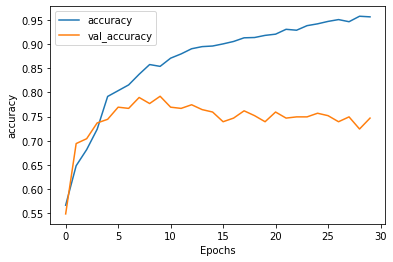

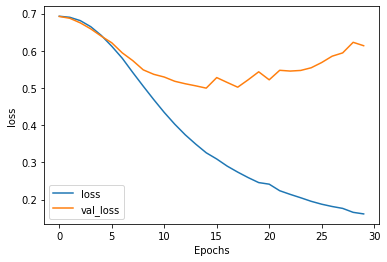

In [20]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' +string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' +string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Get Files For Visualizing The Network
The code below will download two files for visualizing how your network "sees" the sentiment related to each word. Head to http://projector.tensorflow.org/ and load these files, then click the checkbox to "sphereize" the data.

Note: You may run into errors with the projection if your vocab_size earlier was larger than the actual number of words in the vocabulary, in which case you'll need to decrease this variable and re-train in order to visualize.

In [21]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [0]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding = 'utf-8')
out_m = io.open('meta.tsv', 'w', encoding = 'utf-8')

for word_num in range(0, vocab_size - 1):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write('\t' .join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')